# Find the best location to open a fast food restaurant in New York
Couresa Data Science Course Final Assignment - Capstone Project
**************

# Introduction
Selecting a location for a business is one of the most important decisions in running a business. Business decision-makers need to consider different factors in finding the right location for the business, such as financial factors, market factors, and the factors that will affect their demand and revenue. This project can help those who plan to open a new fast food Restaurant and need to find the best location for the restaurant in NY.

# Business Problem
Finding the best location to start a new business in a large city such as NY is challenging. NY has more than 170 neighborhoods with various places that attract tourists and people to visit. Neighborhoods of NY are different in terms of factors that can directly or indirectly affect business success. For an informed decision, it is essential to evaluate all neighborhoods based on the factors that affect running a successful business, such as the number of competitors and the potential demand in each neighborhood. Budget limitations in renting or buying a place also play an essential role in this decision-making, especially for small businesses.  

In this project, We want to help a client find the best neighborhood in NY to open a fast food restaurant. Finding a neighborhood that is close enough to some amenities and venues, has fewer competitors, and is affordable is challenging for our client. A fast food restaurant is good near a place where many people visit, such as near a cinema, park, office, playground, etc. Also, the client has a limited budget, and a neighborhood with fewer competitors is less risky for him/her to start the business. 

In [1]:
# import libs
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim

import folium 
from folium.features import CustomIcon
from folium.plugins import MarkerCluster

import foursquare
from pandas.io.json import json_normalize

from pathlib import Path

from sklearn.cluster import KMeans
from sklearn import preprocessing


import matplotlib.cm as cm
import matplotlib.colors as colors

# Data

## Rent Data
Download one bed room rent data for each neighborhood from https://streeteasy.com/blog/data-dashboard/?agg=Total&metric=Inventory&type=Rentals&bedrooms=Any%20Bedrooms&property=Any%20Property%20Type&minDate=2010-01-01&maxDate=2020-10-01&area=Flatiron,Brooklyn%20Heights. Use the data from Nov 2019 to Oct 2020 to calculate the average rent for each neighborhood.

In [2]:
#load the rent dataset for one bedroom
neighborhood_rent = pd.read_csv("./medianAskingRent_OneBd.csv")

neighborhood_rent = neighborhood_rent[neighborhood_rent['areaType'] == 'neighborhood' ]
neighborhood_rent['Borough'] = neighborhood_rent['Borough'].apply(lambda name : name.upper())
neighborhood_rent['areaName'] = neighborhood_rent['areaName'].apply(lambda name : name.upper())

neighborhood_rent['avg_rent']=neighborhood_rent[['2019-11','2019-12','2020-01','2020-02','2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10']].mean(axis=1)
neighborhood_rent = neighborhood_rent[['areaName','Borough', 'avg_rent']]

#calculate the average rent for each borough
borough_avg = neighborhood_rent.groupby('Borough')['avg_rent'].agg(np.mean)


#replace the nan with the average rent for that borough
def repl_nan_with_avg(row):
    if np.isnan(row['avg_rent']):
        row['avg_rent'] = borough_avg[row['Borough']]
    
    return row
    
neighborhood_rent = neighborhood_rent.apply(repl_nan_with_avg, axis = 1)
neighborhood_rent = neighborhood_rent[neighborhood_rent["areaName"] !='KEW GARDENS HILLS']


neighborhood_rent.head()

,areaName,Borough,avg_rent
5,ASTORIA,QUEENS,1954.833333
6,AUBURNDALE,QUEENS,1600.000000
7,BATH BEACH,BROOKLYN,1647.571429
8,BATTERY PARK CITY,MANHATTAN,3679.916667
9,BAY RIDGE,BROOKLYN,1726.750000


## Location Data

Download the coordinates for each neighborhood through geopy API

In [3]:
# download the longitude and latitude and save into a csv file so that do not need to download everytime

geolocator = Nominatim(user_agent="to_explorer")

def get_location(row):
    address = row["areaName"] + " " + row["Borough"] + " " + "NEW YORK"
    location = geolocator.geocode(address, timeout=None)
    
    if(location == None): 
        address = row["areaName"] + " NEW YORK"
        location = geolocator.geocode(address, timeout=None)
    
    if(location != None):
        row['latitude'] = location.latitude
        row['longitude'] = location.longitude
        print('The geograpical coordinate of {} are {}, {}.'.format(address, location.latitude, location.longitude))
    return row

rent_csv = Path('./neighborhood_rent.csv')

# check the venues data is explored and downloaded 
if( rent_csv.exists() ):
    print("neighborhood_rent.csv is exist, will not download data again.")
else:
    neighborhood_rent = neighborhood_rent.apply(get_location, axis = 1)

    neighborhood_rent = neighborhood_rent.reindex()
    neighborhood_rent.to_csv('./neighborhood_rent.csv')
    


neighborhood_rent.csv is exist, will not download data again.


In [4]:
neighborhood_rent = pd.read_csv('./neighborhood_rent.csv')
neighborhood_rent.drop(['Unnamed: 0'], axis=1, inplace=True)
neighborhood_rent.head()


,Borough,areaName,avg_rent,latitude,longitude
0,QUEENS,ASTORIA,1954.833333,40.772015,-73.930267
1,QUEENS,AUBURNDALE,1600.000000,40.761452,-73.789724
2,BROOKLYN,BATH BEACH,1647.571429,40.601850,-74.000501
3,MANHATTAN,BATTERY PARK CITY,3679.916667,40.711017,-74.016937
4,BROOKLYN,BAY RIDGE,1726.750000,40.633993,-74.014584


Show each neighborhood in the map of NY

In [5]:
address = 'NEW YORK'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of NY are {}, {}.'.format(latitude, longitude))

# create map of Boston using latitude and longitude values of the neighborhoods
import folium 
map_ny = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(neighborhood_rent['latitude'], neighborhood_rent['longitude'], neighborhood_rent['areaName']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  
            
map_ny

The geograpical coordinate of NY are 40.7127281, -74.0060152.


## Use Foursquare API to get venues info for each neighborhoods:

Looking for Movie Theater, Playground, Park, Event Space, General Entertainment, Stadium, Amphitheater, Aquarium, School, Pedestrian Plaza, and Office venues in walking distance (500 meters) from each of these neighborhood. These venues are places that many people usually visit them hence it will bring good demand for fast food. 

In [6]:

# Please refer https://developer.foursquare.com/docs/resources/categories. 

vn_categories = {
    
    'Movie Theater': '4bf58dd8d48988d17f941735',
    'Playground': '4bf58dd8d48988d1e7941735',
    'Park': '4bf58dd8d48988d163941735',
    'Event Space': '4bf58dd8d48988d171941735',
    'General Entertainment': '4bf58dd8d48988d1f1931735',
    'Stadium' : '4bf58dd8d48988d184941735',
    'Amphitheater' :'56aa371be4b08b9a8d5734db',
    'School' : '4bf58dd8d48988d13b941735',
    'Pedestrian Plaza': '52e81612bcbc57f1066b7a25',
    'Office': '4bf58dd8d48988d124941735'
}

', ' .join([ cat for cat in vn_categories])

'Movie Theater, Playground, Park, Event Space, General Entertainment, Stadium, Amphitheater, School, Pedestrian Plaza, Office'

In [7]:
CLIENT_ID = 'HFKPGAAUBI2BYFTPOLTNWY3MD2ZIQ0NONMMIHNSQMCW1F2Q0' # your Foursquare ID
CLIENT_SECRET = 'SVXLBTOZKDQMTDJG1WCTC3NVJGUFVAN2E0B22UQTE2KZJXM1' # your Foursquare Secret
ACCESS_TOKEN = 'PUL4ED0UBZMEABGS5QJKMN40H44BQJEOFKTOYSOHEV031SKC' # your FourSquare Access Token

fs = foursquare.Foursquare( CLIENT_ID, CLIENT_SECRET)
RADIUS = 500 

def venues_nearby(latitude, longitude, category, category_list, neighborhoodName, verbose=True):    
    results = fs.venues.search(
        params = {
            'query': category, 
            'll': '{},{}'.format(latitude, longitude),
            'radius': RADIUS,
            'categoryId': category_list[category]
        }
    )    
    df = json_normalize(results['venues'])
    cols = ['Name','Latitude','Longitude']    
    if( len(df) == 0 ):        
        df = pd.DataFrame(columns=cols)
    else:        
        df = df[['name','location.lat','location.lng']]
        df.columns = cols
    if( verbose ):
        print('{} "{}" venues are found within {}m of location {}'.format(len(df), category, RADIUS, neighborhoodName))
    return df

In [8]:
venues_csv = Path('./neighborhood_venues.csv')
df_venues = None

# check the venues data is explored and downloaded 
if( venues_csv.exists() ):
    neighborhood_venues = pd.read_csv('./neighborhood_venues.csv')
else:    
    neighborhood_venues = pd.DataFrame(columns=[ 'Category','Latitude', 'Longitude'])
    for name, lat, lng , avg_rent, name in zip(neighborhood_rent["areaName"], neighborhood_rent["latitude"], neighborhood_rent["longitude"], neighborhood_rent["avg_rent"], neighborhood_rent["areaName"]):
        for cat in vn_categories:
            df = venues_nearby(lat, lng, cat, vn_categories, name)
            df['Neighborhood'] = name
            df['Average Rent'] = avg_rent
            df['Category'] = cat
            neighborhood_venues = neighborhood_venues.append(df, sort=True)
    neighborhood_venues.to_csv('neighborhood_venues.csv', index=False)

neighborhood_venues.head()    

,Average Rent,Category,Latitude,Longitude,Name,Neighborhood
0,1954.833333,Playground,40.770164,-73.927960,Van Alst Playground,ASTORIA
1,1954.833333,Playground,40.768286,-73.931094,Astoria Health Playground,ASTORIA
2,1954.833333,Park,40.772551,-73.937231,Astoria Houses Park,ASTORIA
3,1954.833333,Park,40.772891,-73.934521,Goodwill Park,ASTORIA
4,1954.833333,Event Space,40.771578,-73.926874,Renaissance Event Hall,ASTORIA


## Check the number of venues for each category

<AxesSubplot:xlabel='Venue Category'>

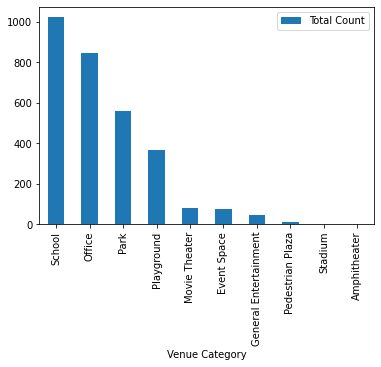

In [9]:
p= neighborhood_venues['Category'].value_counts().to_frame(name='Total Count')
p.index.name = 'Venue Category'
p.plot.bar(y='Total Count')


## Check the number of venues for each neighborhood

In [10]:
#check the number of venues for each neighborhood
df_groupby= neighborhood_venues.groupby('Neighborhood').count().reset_index()
df_groupby = df_groupby[['Neighborhood','Name']]
df_groupby= df_groupby.rename(columns={'Name':'VenueCount'})
df_groupby

,Neighborhood,VenueCount
0,ASTORIA,6
1,AUBURNDALE,6
2,BATH BEACH,9
3,BATTERY PARK CITY,56
4,BAY RIDGE,9
...,...,...
168,WINDSOR TERRACE,15
169,WOODHAVEN,8
170,WOODLAWN,2
171,WOODSIDE,16


## Calculate the number of venus for each category for each neighborhood

In [11]:
# calculate the number of venus for each category for each neighborhood
neighborhood_venues_onehot = pd.get_dummies(neighborhood_venues[['Category']], prefix="", prefix_sep="")#one hot encoding
neighborhood_venues_onehot['Neighborhood'] = neighborhood_venues['Neighborhood'] 
fixed_columns = [neighborhood_venues_onehot.columns[-1]] + list(neighborhood_venues_onehot.columns[:-1])
neighborhood_venues_onehot = neighborhood_venues_onehot[fixed_columns]
neighborhood_venues_onehot = neighborhood_venues_onehot.groupby('Neighborhood').sum().reset_index() 
neighborhood_venues_onehot.head()

neighborhood_venues_onehot[neighborhood_venues_onehot["Neighborhood"]=="GRAMERCY PARK"]

,Neighborhood,Amphitheater,Event Space,General Entertainment,Movie Theater,Office,Park,Pedestrian Plaza,Playground,School,Stadium
72,GRAMERCY PARK,0,1,3,3,30,12,2,7,22,0


## Apply weight for venues
Since different types of venues may attract different number of people so that apply weight to the number of venues.

Below are the weights for each category:

| Category | Weight |
| ----------- | ----------- |
| Movie Theater| 5 |
|Playground   |  1  |
|Park         |  1|
|Event Space  |  5|
|General Entertainment | 5 |
|Stadium | 10 |
|Amphitheater | 10 |
|School |  1 |
|Pedestrian Plaza | 20 |
|Office| 1 |

In [12]:
# different types of venues may attract different number of people so that apply weight to the number of venues

neighborhood_venues_onehot["Event Space"] = neighborhood_venues_onehot["Event Space"] * 5
neighborhood_venues_onehot["General Entertainment"] = neighborhood_venues_onehot["General Entertainment"] * 5
neighborhood_venues_onehot["Movie Theater"] = neighborhood_venues_onehot["Movie Theater"] * 5

neighborhood_venues_onehot["Amphitheater"] = neighborhood_venues_onehot["Amphitheater"] * 10
neighborhood_venues_onehot["Pedestrian Plaza"] = neighborhood_venues_onehot["Pedestrian Plaza"] * 20
neighborhood_venues_onehot["Stadium"] = neighborhood_venues_onehot["Stadium"] * 10

neighborhood_venues_onehot.head()

,Neighborhood,Amphitheater,Event Space,General Entertainment,Movie Theater,Office,Park,Pedestrian Plaza,Playground,School,Stadium
0,ASTORIA,0,5,0,0,0,2,0,2,1,0
1,AUBURNDALE,0,0,0,5,1,0,0,1,3,0
2,BATH BEACH,0,0,0,0,1,1,0,1,6,0
3,BATTERY PARK CITY,0,5,0,5,30,10,80,3,7,0
4,BAY RIDGE,0,0,0,5,3,1,0,2,2,0


## Identify most common venues for each neighborhood

In [13]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#find top 5 most common venues around each neighborhood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues

columns =[ 'Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)

neighborhoods_venues_sorted['Neighborhood'] = neighborhood_venues_onehot['Neighborhood']


for ind in np.arange(neighborhood_venues_onehot.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhood_venues_onehot.iloc[ind, :], num_top_venues)

#neighborhoods_venues_sorted['Average Rent'] = df_boston_nj['Average Rent']
neighborhoods_venues_sorted = pd.merge(neighborhoods_venues_sorted, df_groupby, how="left", left_on="Neighborhood", right_on="Neighborhood" )

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,VenueCount
0,ASTORIA,Event Space,Playground,Park,School,Stadium,6
1,AUBURNDALE,Movie Theater,School,Playground,Office,Stadium,6
2,BATH BEACH,School,Playground,Park,Office,Stadium,9
3,BATTERY PARK CITY,Pedestrian Plaza,Office,Park,School,Movie Theater,56
4,BAY RIDGE,Movie Theater,Office,School,Playground,Park,9


## Find out neighborhood with fast food restaurant

In [14]:
ff_vn_categories = {
    
    'Fast Food Restaurant': '4bf58dd8d48988d16e941735'
}

ff_venues_csv = Path('./neighborhood_fastfood_venues.csv')
neighborhood_ff_venues = None

# check the venues data is explored and downloaded 
if( ff_venues_csv.exists() ):
    neighborhood_ff_venues = pd.read_csv('./neighborhood_fastfood_venues.csv')
else:    
    neighborhood_ff_venues = pd.DataFrame(columns=[ 'Category','Latitude', 'Longitude'])
    for name, lat, lng , avg_rent, name in zip(neighborhood_rent["areaName"], neighborhood_rent["latitude"], neighborhood_rent["longitude"], neighborhood_rent["avg_rent"], neighborhood_rent["areaName"]):
        for cat in ff_vn_categories:
            df = venues_nearby(lat, lng, cat, ff_vn_categories, name)
            df['Neighborhood'] = name
            df['Average Rent'] = avg_rent
            df['Category'] = cat
            neighborhood_ff_venues = neighborhood_ff_venues.append(df, sort=True)
    neighborhood_ff_venues.to_csv('neighborhood_fastfood_venues.csv', index=False)

neighborhood_ff_venues=neighborhood_ff_venues[["Neighborhood","Name"]].groupby("Neighborhood").count()  
neighborhood_ff_venues.rename(columns={"Name": "Fast Food Restaurant"}, inplace=True)
neighborhood_ff_venues.head(10)  

,Fast Food Restaurant
Neighborhood,
EAST HARLEM,1
MIDTOWN EAST,1
MIDTOWN SOUTH,1
NOLITA,1
NORWOOD,1
WILLIAMSBRIDGE,1


# Methodology
To start a new business, we need to select neighborhoods with fewer competitors. For this purpose, we will remove the neighborhoods with fast food restaurant. We will use K-means clustering to classify the neighborhoods based on the nearby venues and their frequencies. To make the decision, we will sort the neighborhoods in each cluster based on their average rent price. A neighborhood with more number of venues, no fast food restaurant, and a lower price will be the best option.

## Remove neighborhood with fast food restaurant

In [15]:
low_competitor = neighborhood_venues_onehot[~neighborhood_venues_onehot['Neighborhood'].isin(neighborhood_ff_venues.index)]

clustering_raw = pd.merge(low_competitor, df_groupby, how="left", left_on="Neighborhood", right_on="Neighborhood" )
clustering_raw = clustering_raw.drop('Neighborhood', 1)
#clustering_raw = preprocessing.normalize(clustering_raw, norm='l2')


kclusters = 5 # set number of clusters


kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering_raw)

low_competitor.insert(0, 'Cluster Label', kmeans.labels_)

low_competitor= pd.merge(low_competitor, neighborhood_rent,how="left", left_on="Neighborhood", right_on="areaName" )

low_competitor.drop(labels=[ 'Borough', 'areaName'], axis= 1, inplace=True)
low_competitor.head()


,Cluster Label,Neighborhood,Amphitheater,Event Space,General Entertainment,Movie Theater,Office,Park,Pedestrian Plaza,Playground,School,Stadium,avg_rent,latitude,longitude
0,0,ASTORIA,0,5,0,0,0,2,0,2,1,0,1954.833333,40.772015,-73.930267
1,0,AUBURNDALE,0,0,0,5,1,0,0,1,3,0,1600.000000,40.761452,-73.789724
2,0,BATH BEACH,0,0,0,0,1,1,0,1,6,0,1647.571429,40.601850,-74.000501
3,2,BATTERY PARK CITY,0,5,0,5,30,10,80,3,7,0,3679.916667,40.711017,-74.016937
4,0,BAY RIDGE,0,0,0,5,3,1,0,2,2,0,1726.750000,40.633993,-74.014584


## Cluster the neighborhood

In [16]:
#visualize the clustered neighborhoods of boston
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)



# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(low_competitor['latitude'], low_competitor['longitude'], low_competitor['Neighborhood'], low_competitor['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [17]:
neighborhoods_venues_sorted_cluster= pd.merge(neighborhoods_venues_sorted, low_competitor, how='left', left_on='Neighborhood', right_on = 'Neighborhood')

neighborhoods_venues_sorted_cluster = neighborhoods_venues_sorted_cluster.drop(neighborhoods_venues_sorted_cluster.columns[range(8,18)], axis=1)

neighborhoods_venues_sorted_cluster.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,VenueCount,Cluster Label,avg_rent,latitude,longitude
0,ASTORIA,Event Space,Playground,Park,School,Stadium,6,0.0,1954.833333,40.772015,-73.930267
1,AUBURNDALE,Movie Theater,School,Playground,Office,Stadium,6,0.0,1600.000000,40.761452,-73.789724
2,BATH BEACH,School,Playground,Park,Office,Stadium,9,0.0,1647.571429,40.601850,-74.000501
3,BATTERY PARK CITY,Pedestrian Plaza,Office,Park,School,Movie Theater,56,2.0,3679.916667,40.711017,-74.016937
4,BAY RIDGE,Movie Theater,Office,School,Playground,Park,9,0.0,1726.750000,40.633993,-74.014584


# Result

## Cluster 1

In [18]:
print("Mean of total venue count: %d" % ( neighborhoods_venues_sorted_cluster[neighborhoods_venues_sorted_cluster['Cluster Label'] == 0]["VenueCount"].mean() ))
neighborhoods_venues_sorted_cluster[neighborhoods_venues_sorted_cluster['Cluster Label'] == 0].sort_values(['avg_rent'], ascending=True).head(5)

Mean of total venue count: 5


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,VenueCount,Cluster Label,avg_rent,latitude,longitude
1,AUBURNDALE,Movie Theater,School,Playground,Office,Stadium,6,0.0,1600.000000,40.761452,-73.789724
155,UNIVERSITY HEIGHTS,School,Playground,Park,Stadium,Pedestrian Plaza,6,0.0,1614.800000,40.861841,-73.913515
14,BOROUGH PARK,Office,Playground,Park,School,Stadium,9,0.0,1628.363636,40.633993,-73.996806
11,BENSONHURST,School,Stadium,Playground,Pedestrian Plaza,Park,5,0.0,1631.916667,40.604977,-73.993406
17,BRONXWOOD,School,Playground,Park,Stadium,Pedestrian Plaza,9,0.0,1643.250000,40.883520,-73.856073


## Cluster 2

In [19]:
print("Mean of total venue count: %d" % ( neighborhoods_venues_sorted_cluster[neighborhoods_venues_sorted_cluster['Cluster Label'] == 1]["VenueCount"].mean() ))
neighborhoods_venues_sorted_cluster[neighborhoods_venues_sorted_cluster['Cluster Label'] == 1].sort_values(['avg_rent'], ascending=True).head(5)

Mean of total venue count: 67


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,VenueCount,Cluster Label,avg_rent,latitude,longitude
29,CHINATOWN,Office,School,Event Space,Movie Theater,Park,78,1.0,2263.750000,40.716491,-73.996250
92,LITTLE ITALY,Office,Event Space,School,Movie Theater,General Entertainment,64,1.0,2541.500000,40.719273,-73.998215
54,EAST VILLAGE,Movie Theater,Office,School,General Entertainment,Event Space,75,1.0,2756.416667,40.729269,-73.987361
96,LOWER EAST SIDE,School,Event Space,Office,Park,Playground,60,1.0,2863.583333,40.715936,-73.986806
31,CIVIC CENTER,Office,School,Park,Movie Theater,Playground,75,1.0,3200.132071,40.713679,-74.002404


## Cluster 3

In [20]:
print("Mean of total venue count: %d" % ( neighborhoods_venues_sorted_cluster[neighborhoods_venues_sorted_cluster['Cluster Label'] == 2]["VenueCount"].mean() ))
neighborhoods_venues_sorted_cluster[neighborhoods_venues_sorted_cluster['Cluster Label'] == 2].sort_values(['avg_rent'], ascending=True).head(5)

Mean of total venue count: 77


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,VenueCount,Cluster Label,avg_rent,latitude,longitude
72,GRAMERCY PARK,Pedestrian Plaza,Office,School,Movie Theater,General Entertainment,80,2.0,3554.833333,40.737925,-73.985932
3,BATTERY PARK CITY,Pedestrian Plaza,Office,Park,School,Movie Theater,56,2.0,3679.916667,40.711017,-74.016937
58,FINANCIAL DISTRICT,Pedestrian Plaza,Office,School,Park,Movie Theater,96,2.0,3765.500000,40.707612,-74.009378


## Cluster 4

In [21]:
print("Mean of total venue count: %d" % ( neighborhoods_venues_sorted_cluster[neighborhoods_venues_sorted_cluster['Cluster Label'] == 3]["VenueCount"].mean() ))
neighborhoods_venues_sorted_cluster[neighborhoods_venues_sorted_cluster['Cluster Label'] == 3].sort_values(['avg_rent'], ascending=True).head(5)

Mean of total venue count: 18


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,VenueCount,Cluster Label,avg_rent,latitude,longitude
53,EAST TREMONT,School,Park,Office,Playground,Stadium,15,3.0,1575.000000,40.845378,-73.890969
64,FORDHAM,School,Park,Office,Event Space,Playground,22,3.0,1591.000000,40.861475,-73.890544
20,BROWNSVILLE,School,Event Space,Office,Stadium,Playground,14,3.0,1612.333333,40.660937,-73.920137
89,KINGSBRIDGE,School,Park,Playground,Stadium,Pedestrian Plaza,16,3.0,1671.166667,40.878705,-73.905141
7,BEDFORD PARK,Park,General Entertainment,Playground,Office,School,14,3.0,1688.400000,40.870100,-73.885691


## Cluster 5

In [22]:
print("Mean of total venue count: %d" % ( neighborhoods_venues_sorted_cluster[neighborhoods_venues_sorted_cluster['Cluster Label'] == 4]["VenueCount"].mean() ))
neighborhoods_venues_sorted_cluster[neighborhoods_venues_sorted_cluster['Cluster Label'] == 4].sort_values(['avg_rent'], ascending=True).head(5)

Mean of total venue count: 42


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,VenueCount,Cluster Label,avg_rent,latitude,longitude
13,BOERUM HILL,Pedestrian Plaza,School,Event Space,Office,Movie Theater,34,4.0,2648.500000,40.685626,-73.984171
156,UPPER EAST SIDE,School,Park,Playground,Office,Stadium,39,4.0,2881.583333,40.773702,-73.964120
108,MORNINGSIDE HEIGHTS,Office,Park,School,Movie Theater,Event Space,32,4.0,3034.916667,40.810000,-73.962500
66,FORT GREENE,School,Movie Theater,Playground,Office,Park,38,4.0,3040.666667,40.690771,-73.976624
18,BROOKLYN HEIGHTS,Park,Office,School,Playground,Stadium,44,4.0,3083.333333,40.696085,-73.995028


# Conclusion

According to the result of our analysis, GRAMERCY PARK (in cluster 3) is the best neighborhood to open an fast food restaurant in NY. It has the most number of total venues and is expected to attract many people to visit. This neighborhood has 2 Pedestrian Plaza, 7 playground, 30 offices and no fast food restaurant within walking distance is the best option. Furthermore, the average rent in this neighborhood is the lowest one in cluster 3. 




# Discussion

We used the information about the neighborhoods of NY to help my client to select the best location to open an ice cream shop in Boston. We considered number of competitors, demand for fast food restaurant, and budget limitations to find the best location options. 

This project has some limitations. First, we have limited the location options to the neighborhoods of NY, however considering more specific locations such as particular streets can improve the accuracy of our decision. Second, we used the average one bedroom rent price in each neighborhood as an estimate of the rent price. Third, we limited our investigation for the venues within 500 meter of the neighborhoods and changing it can affect the clusters. 